### Importações


## Testando o Ridge

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_households,population_per_households,bedrooms_per_rooms
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   longitude                  17564 non-null  float32 
 1   latitude                   17564 non-null  float32 
 2   housing_median_age         17564 non-null  int8    
 3   total_rooms                17564 non-null  int16   
 4   total_bedrooms             17564 non-null  int16   
 5   population                 17564 non-null  int16   
 6   households                 17564 non-null  int16   
 7   median_income              17564 non-null  float32 
 8   median_house_value         17564 non-null  int32   
 9   ocean_proximity            17564 non-null  category
 10  median_income_cat          17564 non-null  int64   
 11  rooms_per_households       17564 non-null  float32 
 12  population_per_households  17564 non-null  float32 
 13  bedrooms_per_rooms         1756

Separando colunas categóricas, target e categóricas ordinais, para cada tratamento 

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

Colunas numéricas para tratamento com RobustScaler

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_rooms', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_households',
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object')

Ciando a pipeline

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_households,population_per_households,bedrooms_per_rooms
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Definindo os parametros

In [10]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree":[1,2,3],
    "regressor__reg__alpha": [1E-2,5E-2,0.1,02.25,0.5,1.0,2.0,5.0,10.0,20.0,50.0],
}

Criando o grid_search com Ridge

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 2.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Treinando o meodelo

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 2.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [14]:
grid_search.best_score_

np.float64(-50459.78088948543)

Visualizando a atuação de cada coeficiente

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.021062
robust_scaler_poly__latitude,-0.956152
one_hot__ocean_proximity_INLAND,-0.461582
robust_scaler_poly__latitude longitude population_per_households,-0.419054
robust_scaler_poly__population_per_households,-0.331011
...,...
robust_scaler_poly__latitude^2 longitude,0.245366
robust_scaler_poly__housing_median_age median_income,0.245872
robust_scaler_poly__latitude median_income population_per_households,0.252805
robust_scaler_poly__bedrooms_per_rooms,0.337126


Devido a utilização do PolynomialFeatures temos muitas features que aumenta a complexidade

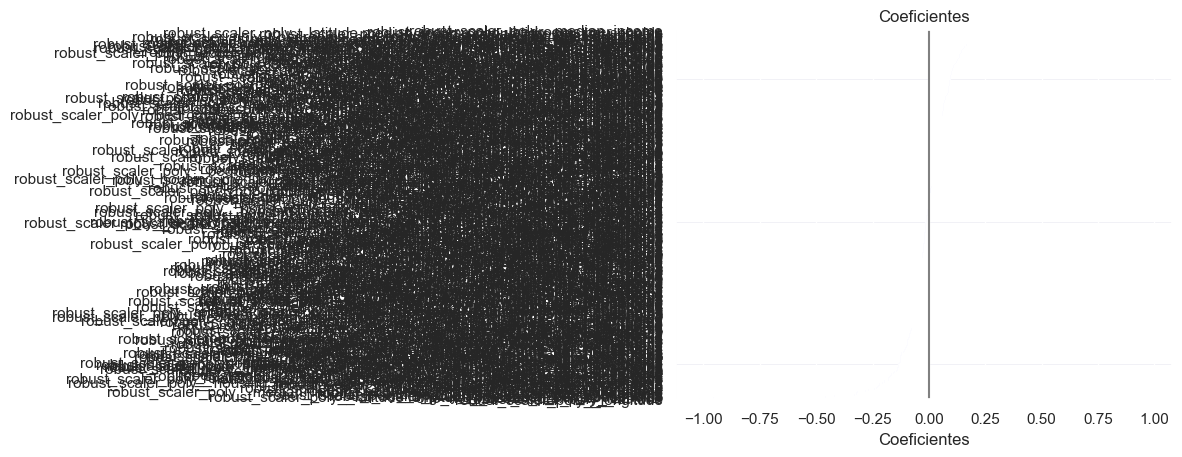

In [16]:
plot_coeficientes(coefs)

In [17]:
coefs[coefs["coeficiente"]==0]

,coeficiente


In [18]:
coefs[coefs["coeficiente"].between(-0.2,0.2)]

,coeficiente
one_hot__ocean_proximity_NEAR BAY,-0.197058
robust_scaler_poly__households median_income^2,-0.182103
robust_scaler_poly__longitude median_income,-0.181756
robust_scaler_poly__housing_median_age median_income population_per_households,-0.180435
robust_scaler_poly__bedrooms_per_rooms rooms_per_households,-0.179126
...,...
robust_scaler_poly__total_bedrooms,0.168848
robust_scaler_poly__bedrooms_per_rooms rooms_per_households total_bedrooms,0.173305
robust_scaler_poly__median_income population population_per_households,0.175659
robust_scaler_poly__median_income population rooms_per_households,0.177299


Separando em uma faixa de valores menor para se ter uma melhor visualização

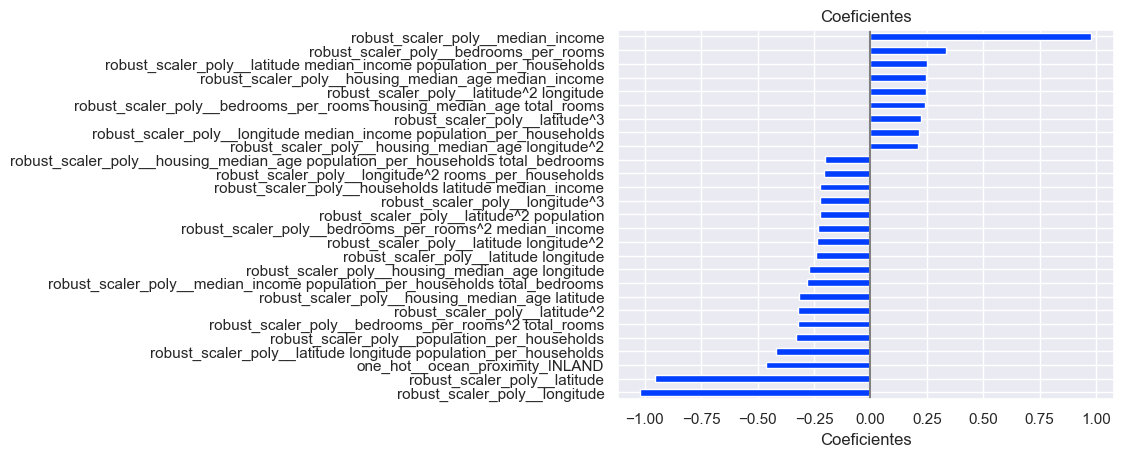

In [19]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2,0.2)])

Comparando os regressores

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002829,0.003128,-0.000081,-77516.042766,-96239.705692,0.005956
1,DummyRegressor,0.001853,0.003284,-0.000146,-75787.787194,-95217.629397,0.005137
2,DummyRegressor,0.001952,0.003487,-0.001737,-76753.598961,-96253.253947,0.005439
3,DummyRegressor,0.002102,0.003336,-0.000101,-76837.804811,-95983.885799,0.005439
4,DummyRegressor,0.002133,0.003433,-0.000114,-76617.245449,-96182.764729,0.005566
5,LinearRegression,0.021762,0.009155,0.682162,-39855.690996,-54254.958188,0.030917
6,LinearRegression,0.020764,0.007452,0.66999,-40272.565467,-54695.230283,0.028216
7,LinearRegression,0.017664,0.007383,0.649247,-42178.05929,-56955.988706,0.025047
8,LinearRegression,0.017702,0.009277,0.669873,-40806.492497,-55146.318803,0.026979
9,LinearRegression,0.017372,0.007251,0.669023,-40788.496497,-55331.35106,0.024622


In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002174,0.003334,-0.000436,-76702.495836,-95975.447913,0.005507
LinearRegression,0.019053,0.008104,0.668059,-40780.26095,-55276.769408,0.027156
LinearRegression_target,0.024172,0.008684,0.67818,-38672.752269,-54423.27559,0.032857
Ridge_grid_search,0.092179,0.015315,0.723418,-35344.654122,-50445.373875,0.107494


In [22]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002174,0.003334,-0.000436,-76702.495836,-95975.447913,0.005507
LinearRegression,0.019053,0.008104,0.668059,-40780.26095,-55276.769408,0.027156
LinearRegression_target,0.024172,0.008684,0.67818,-38672.752269,-54423.27559,0.032857
Ridge_grid_search,0.092179,0.015315,0.723418,-35344.654122,-50445.373875,0.107494


Nota-se que o Ridge teve as melhores métricas com uma penalização de 3 vezes o tempo de processamento, devido a utilização do PolynomialFeature grau 3 

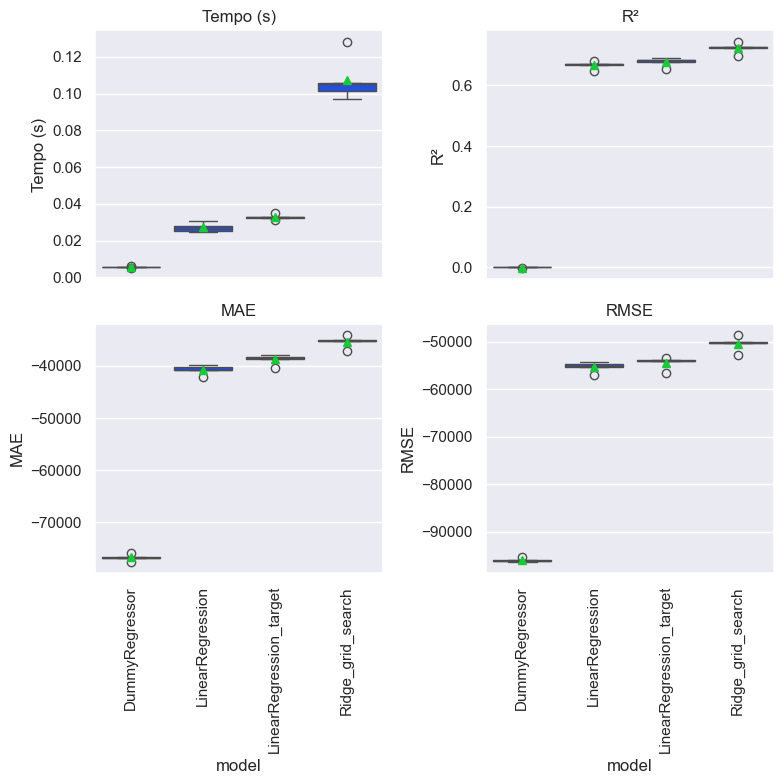

In [23]:
plot_comparar_metricas_modelos(df_resultados)

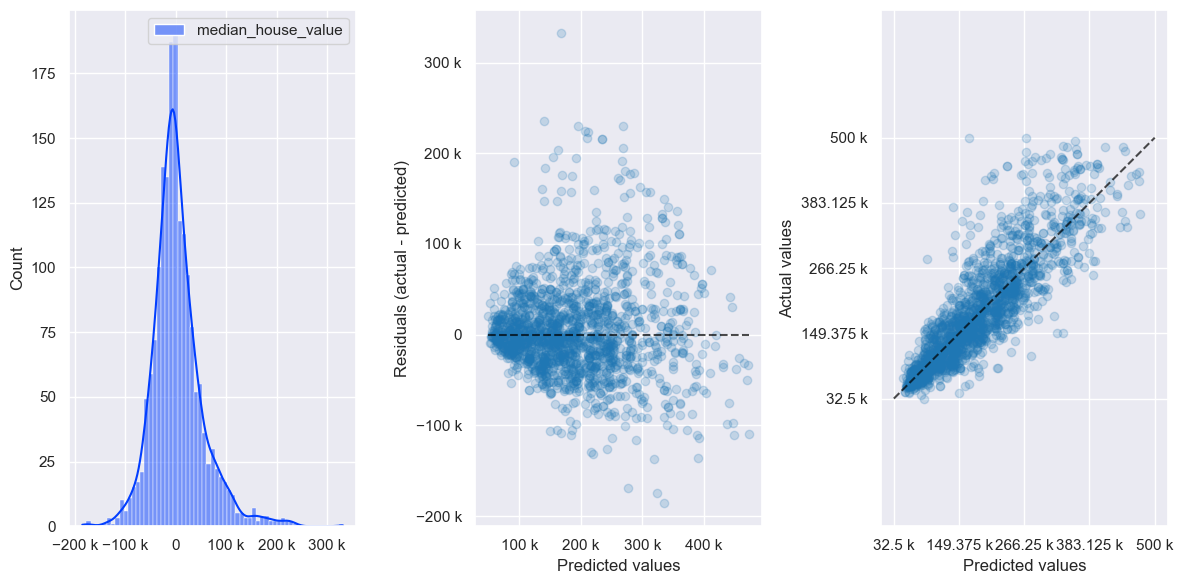

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

Salvando o modelo para ser utilizado no StreamLit

In [25]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\User\\Desktop\\GDrive\\Ciência de Dados\\Machine Learning\\Regressão Linear\\05_projeto\\modelos\\ridge_polyfeat_target_quantile.joblib']